## Visualizaciones en Python

<IMG SRC="https://drive.google.com/uc?id=1Iq3EBhKVqU-Y93ufhxD84m4dF3E5EVs2" HEIGHT=300>
<IMG SRC="https://drive.google.com/uc?id=1mFv6b0UXCNkFjDS5QhVPTrV3c6vfj7BS" HEIGHT=300>
<IMG SRC="https://drive.google.com/uc?id=1C0vFCGUNBJB66owaT0vF0Uy8VhNYCsLB" HEIGHT=300>

Retomamos nuestros seminarios de datos y Python con una revisión de las populares herramientas para generar visualizaciones en Python. La estructura será la siguiente:
0. Matplotlib (el punto base)
1. Seaborn (estadísticas): heatmap, boxplot, pairplot, pairgrid, violines.
2. Plot.ly/Dash: visualizaciones interactivas
3. Cartografía Digital: folium, kepler.gl, geoplotlib
4. D3.js: ¿para qué cresta aprender otro lenguaje?
5. Tópicos avanzados: altair (otro expositor), vax? Joyplot, EOD...

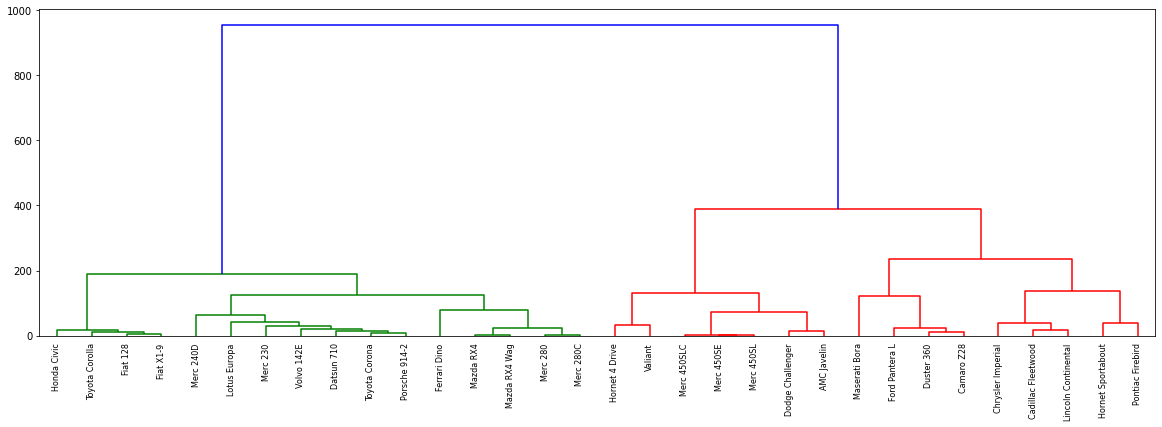

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
 
url = 'https://gist.github.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv'
fig, ax = plt.subplots(1, figsize=(20,6))
df = pd.read_csv(url)
df = df.set_index('model')
Z = linkage(df, 'ward')
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df.index)
plt.show()

##0. Matplotlib, el amigo por defecto.
Nada más básico y fome, pero en muchos casos es inevitable volver a usarlo y lo veremos por aquí y por allá, por ejemplo para definir el tamaño de una figura y ponerle título, rotar los ejes, aunque el gráfico haya sido creado en otra librería. Por eso pasamos directo a seaborn.
##1. Seaborn, gráficos estadísticos.
La visualización fue definida por el abuelo Edward E. Tufte (investiguen) como "el arte de condensar datos en un espacio bidimensional para obtener información visual". 
En muchos casos nos interesa visualizar datos del mundo real cuya idea física entendemos, no así sus relaciones internas. Vamos con un ejemplo, los precios de combustibles que nos da la [página de la Comisión Nacional de Energía](https://api.cne.cl/apidocs/) , la CNE.

In [ ]:
import pandas as pd    # como siempre, nuestro mejor aliado para leer y manipular datos
gdf = pd.read_csv('https://github.com/sergiolucero/pydatachile/raw/master/CNE_precios_Abril2021.csv')
gdf.sample(3)

,distribuidor,fecha,id_region,comuna,región,p93,p95,p97,latitud,longitud,dirección
100,Shell,2021-04-23 15:24:05,3,Copiapó,Atacama,862.0,891.0,922.0,-27.371648,-70.333030,Copayapu 852
94,Petrobras,2021-04-22 09:35:05,3,Copiapó,Atacama,862.0,891.0,922.0,-27.371715,-70.331571,Av. Copayapu 957
662,Sin bandera,2021-04-08 01:09:40,7,Retiro,Del Maule,820.0,851.0,0.0,-36.198883,-71.626066,Sector Quillaimo Km. 20 0


Lo primero, como siempre, es verificar qué tan limpios vienen los datos. Por ejemplo, se nos colaron fechas añejas, lo que distorsiona por cierto cualquier análisis.

In [ ]:
print('(antes) RANGO FECHAS:', gdf['fecha'].min(), '->', gdf['fecha'].max())
gdf = gdf[gdf['fecha']>='2021-04-18']
print('(después) RANGO FECHAS:', gdf['fecha'].min(), '->', gdf['fecha'].max())

(antes) RANGO FECHAS: 2021-04-18 10:08:47 -> 2021-04-25 10:34:31
(después) RANGO FECHAS: 2021-04-18 10:08:47 -> 2021-04-25 10:34:31


Tenemos datos numéricos para los precios de 3 tipos de gasolina, además de información geográfica (comuna, región, y dirección, además de latitud y longitud). Dejaremos esto último para las secciones finales, por ahora nos interesa analizar variabilidad numérica. Por ejemplo, en qué región es más cara cada gasolina? Visualmente, una idea básica es tomar una tabla *heatmap*:

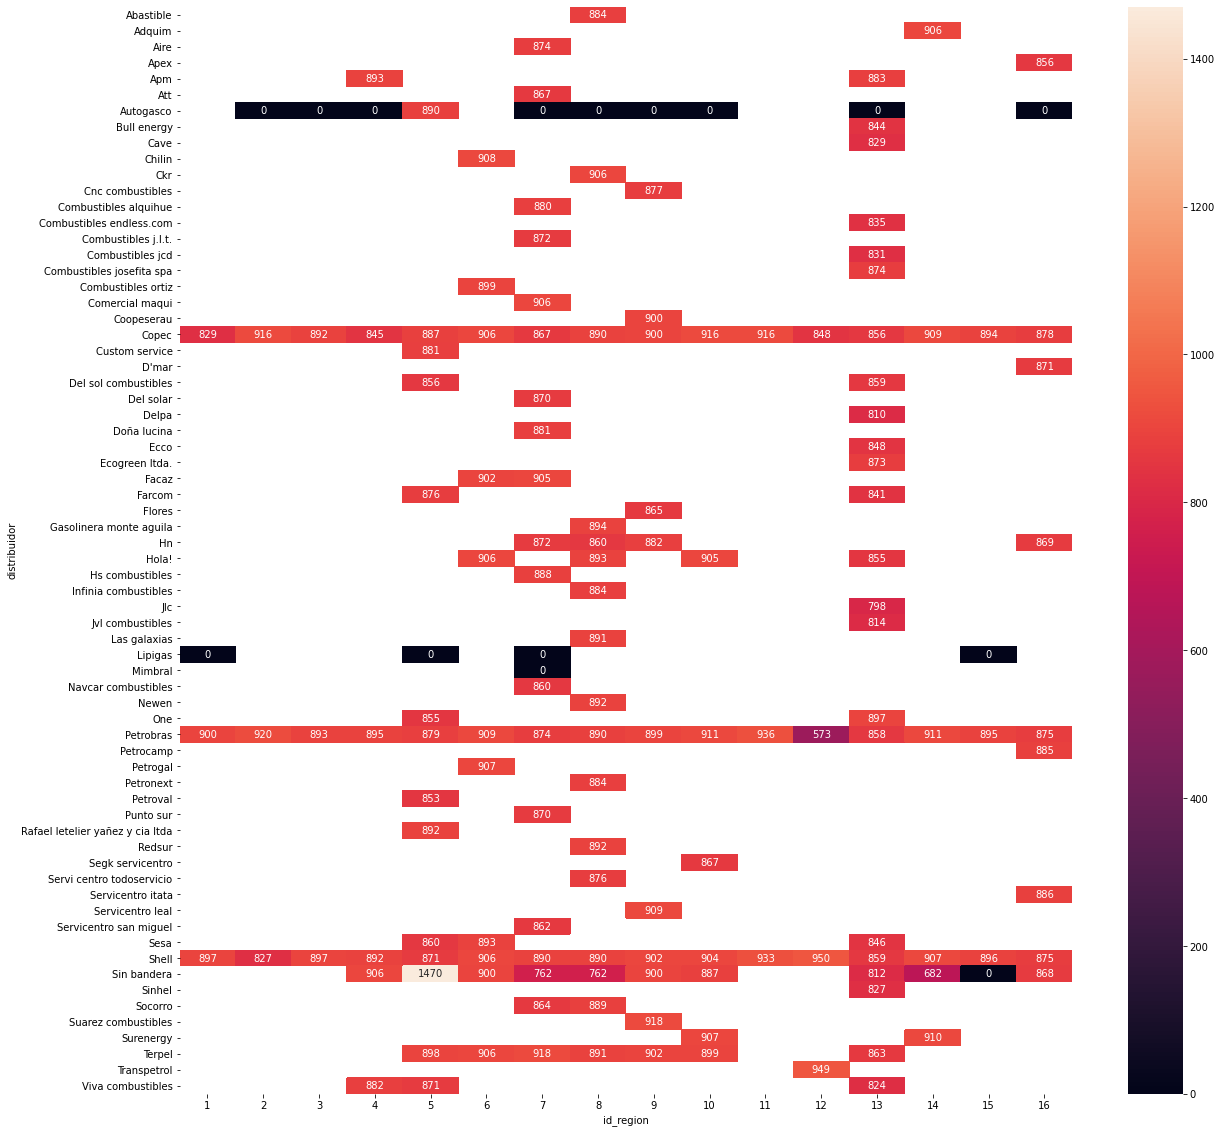

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(20,20))  # 1 sólo gráfico, en un cuadrado
pdf = gdf.pivot_table(index='distribuidor', columns='id_region',  values='p95') # qué dimensión queremos en cada eje: x,y,z
sns.heatmap(pdf, annot=True, fmt='.0f');

Esta es claramente demasiada variedad, restrinjamos el estudio a las cadenas más populares: Copec, Petrobras y Shell. Vemos de paso que hay gasolineras con precios cero (no venden ese tipo) que debiéramos eliminar.

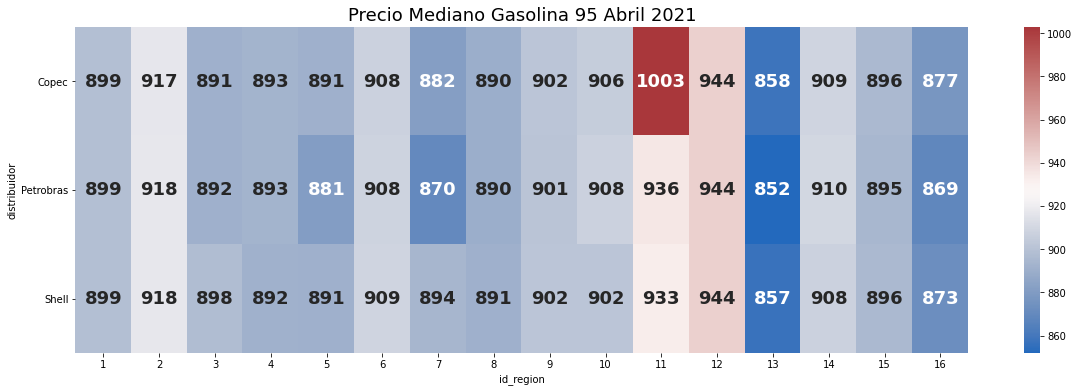

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,6))
pop_df = gdf[gdf['distribuidor'].isin(['Copec', 'Petrobras','Shell'])]
pop_df = pop_df[pop_df!=0]
pdf2 = pop_df.pivot_table(columns='id_region', index='distribuidor', 
                          values='p95', aggfunc='median')
sns.heatmap(pdf2, annot=True, annot_kws={'size':18, 'weight': 'bold'}, 
            fmt='.0f', cmap='vlag');
plt.yticks(rotation=0);plt.title('Precio Mediano Gasolina 95 Abril 2021', size=18);

Somos ahora libres de emitir opiniones informadas sobre estos datos a partir de la primera visualización. Claramente, los mejores precios están en la Región Metropolitana. Y los más altos, en la 11ava región de Aisén, donde el clásico "póngale luca" no te da ni para un litro en la COPEC. Más al sur, en la 12ava de Magallanes, hay precios mejores (subsidiados?). Hagamos un zoom en estas comunas, utilizando un gráfico de tipo boxplot. Para aclarar el gráfico, agregamos una nueva columna llamada "region_comuna". Explorando los datos, vemos también que en algunas latitudes extremas (como en Primavera, ubicada a tiernos 3000 kms de Santiago) sólo se vende gasolina 93, así que modificamos nuestro foco.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


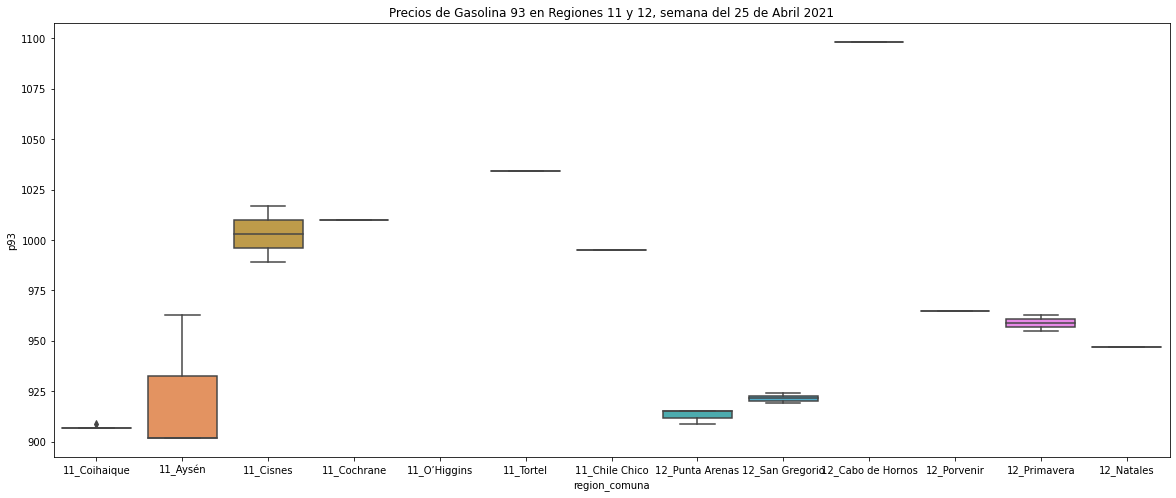

In [ ]:
p11y12 = pop_df[pop_df.id_region.isin([11,12])]
p11y12['region_comuna'] = [f'{id_region}_{comuna}'  
                           for id_region, comuna in zip(p11y12['id_region'],p11y12['comuna'])] 
fig, ax = plt.subplots(1, figsize=(20,8))
sns.boxplot(data=p11y12, x='region_comuna', y='p93');
plt.title('Precios de Gasolina 93 en Regiones 11 y 12, semana del 25 de Abril 2021');

Es muy poca la variabilidad que se observa en este gráfico de cajas, donde una "caja normal" como la 2da y 3ra, nos muestra la mediana, cuartiles 25 y 75... Intentemos repetir el ejercicio con una región más sabrosa, como por ejemplo la 4ta.

In [ ]:
#@title Regiones
region =  8#@param {type:"integer"}

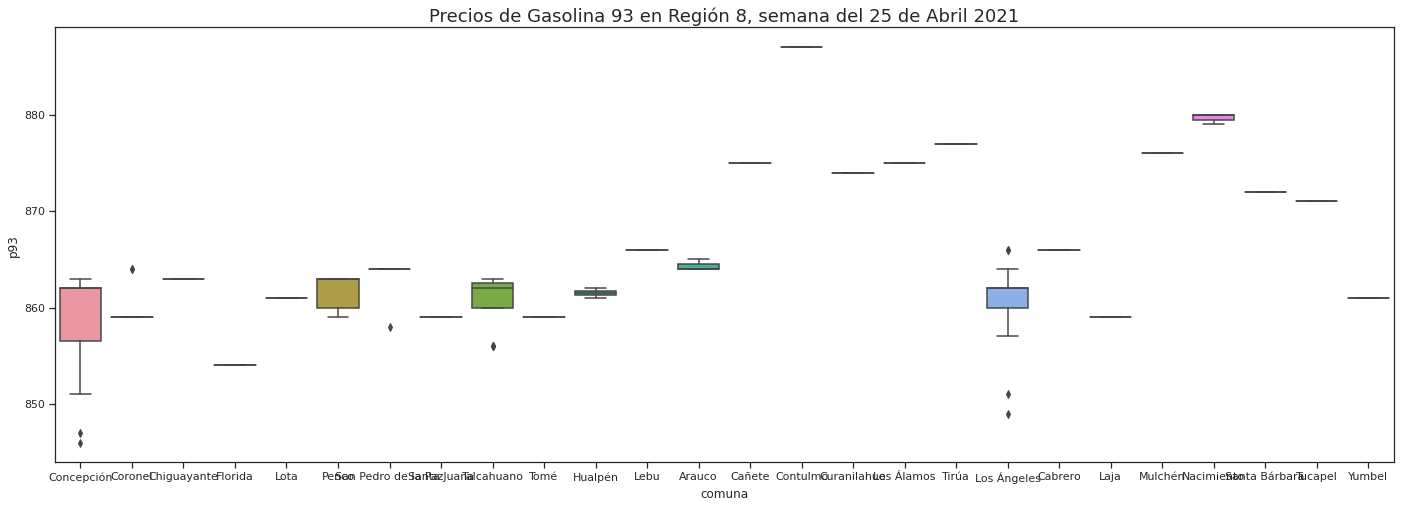

In [ ]:
preg = pop_df[pop_df.id_region==region]
sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(1, figsize=(24,8))
sns.boxplot(data=preg, x='comuna', y='p93');
plt.title(f'Precios de Gasolina 93 en Región {region}, semana del 25 de Abril 2021', size=18);

Las cajas son muy cuadradas, veamos un 3er tipo de gráfico para visualizar la distribución estadística de los precios en por ejemplo la quinta región.

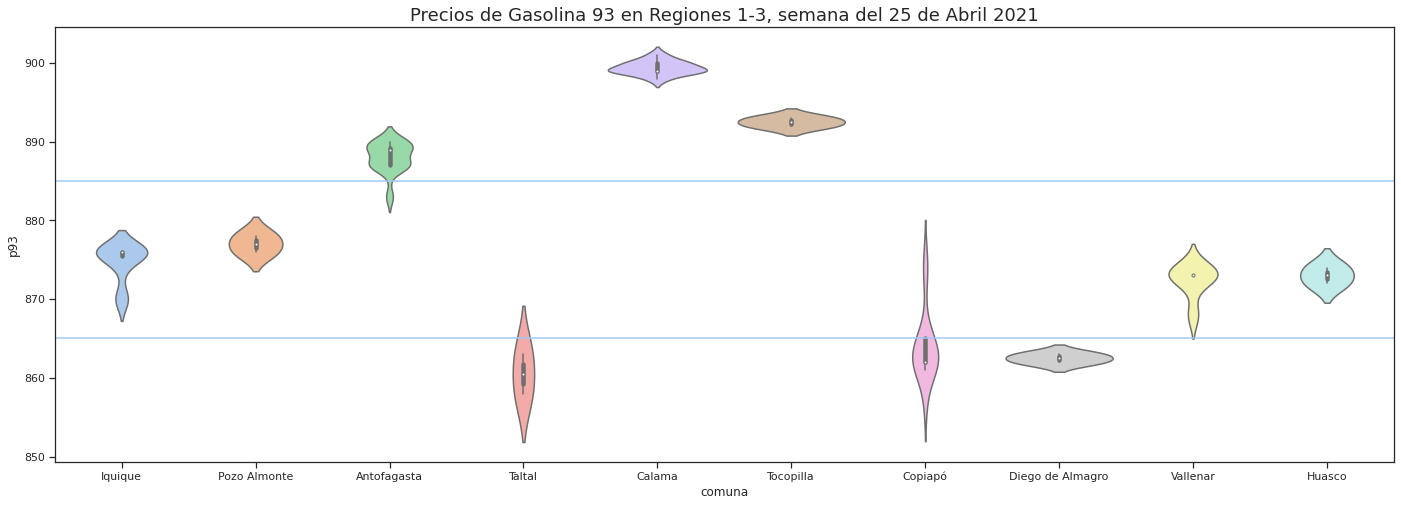

In [ ]:
preg = pop_df[pop_df.id_region<=3]
fig, ax = plt.subplots(1, figsize=(24,8))
preg = preg[~preg.comuna.isin(['Alto Hospicio','Pica','Mejillones','Sierra Gorda',
                               'San Pedro de Atacama','María Elena','Caldera','Tierra Amarilla','Chañaral'])]  # sin variaciones
sns.violinplot(data=preg, x='comuna', y='p93');
plt.axhline(865);plt.axhline(885);
plt.title(f'Precios de Gasolina 93 en Regiones 1-3, semana del 25 de Abril 2021', size=18);

In [ ]:
sns.pairplot(data=preg)

NameError: ignored

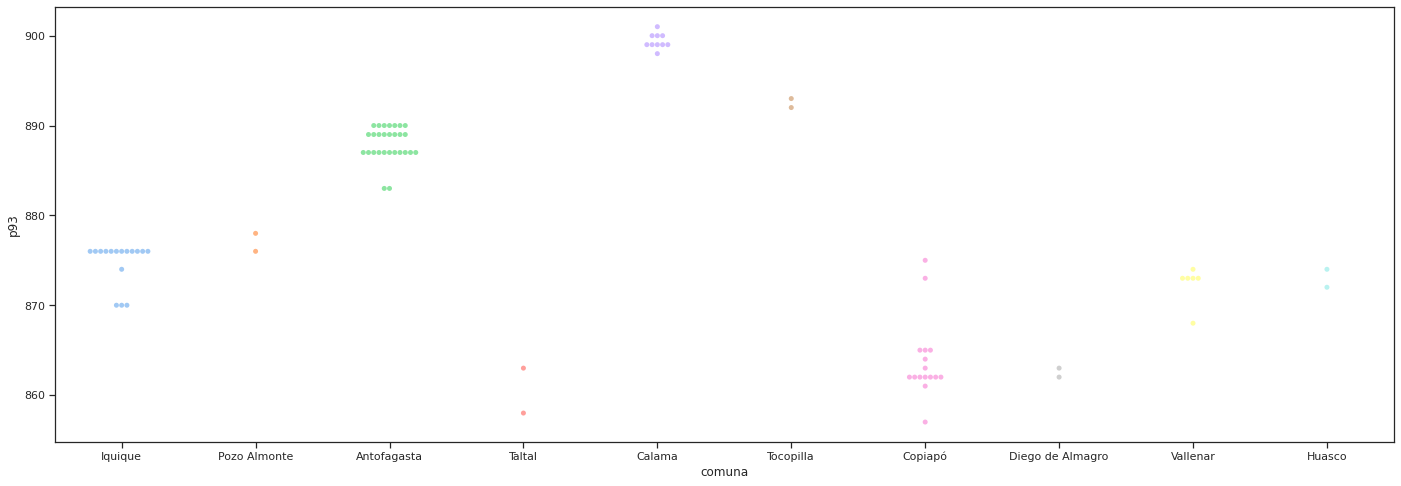

In [ ]:
fig, ax = plt.subplots(1, figsize=(24,8))
sns.swarmplot(data=preg, x='comuna', y='p93');

## Cartografía digital
Tener datos con información geográfica nos invita a visualizar la distribución espacial de las variables numéricas. Generemos algunos ejemplos de cómo llevar esto a cabo con librerías de Python. Por ejemplo, folium es muy sencillo. La idea central es crear un mapa, como una pizarra en blanco, centrada en una ubicación, con ciertas baldosas. A esta pizarra le agregaremos puntos, líneas o polígonos basados en la información que queramos mostrar. Por ejemplo, en nuestro caso, íconos cuyo color dependa de la empresa del distribuidor: Copec, Shell, Petrobras u otros.

In [ ]:
import folium
provi = gdf[gdf.comuna.isin(['Providencia','Recoleta'])]
cd = {'Copec':'blue', 'Shell':'orange', 'Petrobras':'green'}
colorfn = lambda dist: cd.get(dist, 'red')  # el color del resto
fm = folium.Map(location=(-33.43, -70.62), zoom_start=15,
                width=1000, height=400, tiles='StamenToner')
for _, row in provi.iterrows():
  folium.Marker((row['latitud'],row['longitud']), 
                icon=folium.Icon(icon='fa-gas-pump', color=colorfn(row['distribuidor'])),
                popup="Gas93=%d, Dirección=%s" %(row['p93'], row['dirección'])).add_to(fm)
fm

Como no se puede ejecutar en un Google Colab (por ahora), dejamos al alumnado con la tarea de explorar la gran librería kepler.gl

<IMG SRC="https://drive.google.com/uc?id=1sUxCECfL1ts_t2MCDHerQy57hQbkDKk3" HEIGHT=600>


## Plot.ly, una gran librería para gráficos interactivos.
Finalmente mostramos algunos ejemplos de uso de Plot.ly, que sirve mucho para generar dashboards.

In [ ]:
# Plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 40,
      line = dict(color = "black", width = 0.5),
      label = ["Izquierda", "Derecha", "Guillier", "Piñera", "Apruebo", "Rechazo"],
      color = ["red","blue",'pink','purple','orange','cyan']
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Evolución Votos Presidencial 2017 - Plebiscito 2020", 
                  font_size=18)
fig.show()

In [ ]:
import pandas as pd
  
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/718417069ead87650b90472464c7565dc8c2cb1c/sunburst-coffee-flavors-complete.csv')
  
fig = go.Figure()
  
fig.add_trace(go.Sunburst(
    ids = df.ids,
    labels = df.labels,
    parents = df.parents,
    domain = dict(column = 0)
))
  
fig.show()

In [ ]:
import plotly.graph_objects as go

fig =go.Figure(go.Sunburst(
    labels=["Eva", "Caín", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    parents=["", "Eva", "Eva", "Seth", "Seth", "Eva", "Eva", "Awan", "Eva" ],
    values=[10, 14, 12, 10, 2, 6, 6, 4, 4],
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

In [ ]:
from plotly.subplots import make_subplots

import pandas as pd

df1 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/718417069ead87650b90472464c7565dc8c2cb1c/sunburst-coffee-flavors-complete.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/718417069ead87650b90472464c7565dc8c2cb1c/coffee-flavors.csv')

fig = make_subplots(
    rows = 1, cols = 2,
    column_widths = [0.4, 0.4],
    specs = [[{'type': 'treemap', 'rowspan': 1}, {'type': 'treemap'}]]
)

fig.add_trace(
    go.Treemap(
        ids = df1.ids,
        labels = df1.labels,
        parents = df1.parents),
    col = 1, row = 1)

fig.add_trace(
    go.Treemap(
        ids = df2.ids,
        labels = df2.labels,
        parents = df2.parents,
        maxdepth = 3),
    col = 2, row = 1)

fig.update_layout(
    margin = {'t':0, 'l':0, 'r':0, 'b':0}
)

fig.show()